In [46]:
import pandas as pd
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# 1.加载训练集和测试集
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("训练集预览:")
print(train_df.head())
print("\n测试集预览:")
print(test_df.head())

X = train_df['text']
y = train_df['label']
X_test = test_df['text']

训练集预览:
                                                text  label
0  alive billy has drained the earth of power to ...      1
1  my friends , this is really an opportunity tha...      1
2  improve your sex appeal 1 , 000 % i ' ve exper...      1
3  Subject: december 6 th meeting dear mr . kamin...      0
4  dear customer tired of paying twice the price ...      1

测试集预览:
   id                                               text
0   0  it has been taken care of . let me know if you...
1   1  - - - - - - - - - - - - - - - - - - - - - - fo...
2   2  unsubscribe cheater bakelitecargoes scholar ar...
3   3  stop wasting money on prescription drugs . get...
4   4  tendency she wobble snatch blinked up out of t...


In [48]:
# 2. 划分训练集：2/3训练，1/3验证
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.33,  # 1/3作为验证集
    random_state=42,
    stratify=y
)

In [49]:
# 3. 邮件预处理
def preprocess_email(email):
    email = email.lower()
    email = re.sub('<[^<>]+>', ' ', email)
    email = re.sub(r'[0-9]+', 'number', email)
    email = re.sub(r'(http|https)://[^\s]*', 'httpaddr', email)
    email = re.sub(r'[^\s]+@[^\s]+', 'emailaddr', email)
    email = re.sub(r'[$]+', 'dollar', email)
    email = re.sub(r'[^a-zA-Z0-9]', ' ', email)
    tokens = email.split()
    ps = PorterStemmer()
    words = [ps.stem(token) for token in tokens if len(token) > 1]
    return ' '.join(words)

print("\n预处理文本...")
X_train_processed = X_train.apply(preprocess_email)
X_val_processed = X_val.apply(preprocess_email)
X_test_processed = X_test.apply(preprocess_email)



预处理文本...


In [50]:
# 4. 特征提取
print("生成TF-IDF特征...")
vectorizer = TfidfVectorizer(max_features=5000)
X_train_features = vectorizer.fit_transform(X_train_processed)
X_val_features = vectorizer.transform(X_val_processed)  # 验证集使用相同的词汇表
X_test_features = vectorizer.transform(X_test_processed)  # 测试集使用相同的词汇表

生成TF-IDF特征...


In [51]:
# 5. 训练模型
print("\n训练模型...")
model = LinearSVC(C=0.1, max_iter=1000, class_weight='balanced')
model.fit(X_train_features, y_train)


训练模型...


LinearSVC(C=0.1, class_weight='balanced')


训练准确率: 98.33%
验证准确率: 97.91%

验证集分类报告:
              precision    recall  f1-score   support

        正常邮件       0.98      0.97      0.98      8412
        垃圾邮件       0.97      0.98      0.98      8088

    accuracy                           0.98     16500
   macro avg       0.98      0.98      0.98     16500
weighted avg       0.98      0.98      0.98     16500



C:\Users\Alpha\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Alpha\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Alpha\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 37038 (\N{CJK UNIFIED IDEOGRAPH-90AE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Alpha\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Alpha\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 22403 (\N{CJK UNIFIED IDEOGRAPH-5783}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Alpha\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 22334 (\N{CJK UNIFIED IDEOGRAPH-573E}

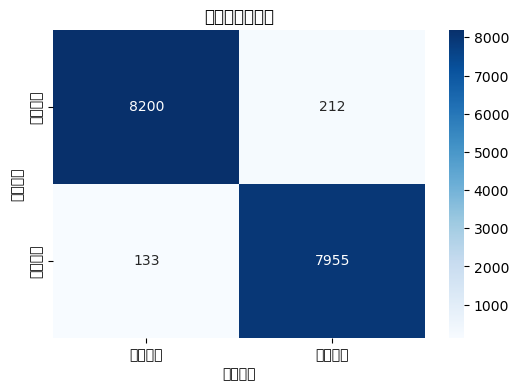

In [64]:
# 6. 评估模型
# 在训练集上评估
train_pred = model.predict(X_train_features)
print(f"\n训练准确率: {accuracy_score(y_train, train_pred)*100:.2f}%")

# 在验证集上评估
val_pred = model.predict(X_val_features)
print(f"验证准确率: {accuracy_score(y_val, val_pred)*100:.2f}%")
print("\n验证集分类报告:")
print(classification_report(y_val, val_pred, target_names=['正常邮件', '垃圾邮件']))

# 绘制验证集混淆矩阵
cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['正常邮件', '垃圾邮件'],
            yticklabels=['正常邮件', '垃圾邮件'])
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title('验证集混淆矩阵')
plt.show()


In [65]:
# 7. 对测试集预测并保存结果
test_pred = model.predict(X_test_features)
test_df['predicted_label'] = test_pred

output_df = pd.DataFrame({
    'id': test_df.index,
    'label': test_df['predicted_label'].astype(int)
})


output_path = "submission.csv"
output_df.to_csv(output_path, index=False)
print(f"\n预测结果已保存至: {output_path}")

# 查看前几行验证格式
print("\n输出文件前5行示例:")
print(pd.read_csv(output_path).head())

# 查看预测分布
print("\n测试集预测分布:")
print(output_df['label'].value_counts())


预测结果已保存至: test_predictions.csv

输出文件前5行示例:
   id  label
0   0      0
1   1      0
2   2      1
3   3      1
4   4      1

测试集预测分布:
label
1    5024
0    4976
Name: count, dtype: int64
